**Introduction**

* Ocean is indispensible to both the ecosystem and human society. It plays a significant role in not only climate regulation and carbon sequestration, but also providing sources of protein to the food chain. Humans, especially those who live in coastal areas, largely rely on the ocean for food. However, due to overfishing, pollution, and other factors, many seafood stocks are at the brink of collapse. A study conducted by Worm et al. (DOI: 10.1126/science.1132294), published on Science, predicts that most seafood fisheries will collapse by 2050.


* Overfishing and by-catches are the two unsustainable fishing practices that threatens the marine ecosystem. In tuna fisheries, overfishing and by-catches are results of illegal, unregulated and unreported catches, which are common in the Western and Central Pacific, according to the Nature Conservancy. On the high seas, monitoring and enforcing legal practices can be difficult due to the remoteness of the location, and the cumbersome amount of raw data (images and videos recorded by fishing ship cameras) to be processed and analyzed manually.


* In the following, a possible solution is provided to address this issue. A Convoluted Neural Network (CNN) model is designed and implemented to predict and classify the species of catches from a set of 8 classes, based on the images recorded by monitoring cameras on fishing ships. This will automate and thus significantly accelerate the reviewing process.


* The dataset is provided by the Nature Conservancy, which contains 8 classes of images with a resolution of 1280x720 pixels, sorted in their class folders, respectively. The 8 classes are Albacore tuna (ALB, Thunnus alalunga), Bigeye tuna (BET, Thunnus obesus), Dolphinfish/Mahi Mahi (DOL, Coryphaena hippurus), Opah/Moonfish (LAG, Lampris guttatus), Sharks (SHARK, various species), Yellowfin tuna (YFT, Thunnus albacares), other species (OTHER), and no-fish (NoF).

**Importing the required libraries and setting the fish category names**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fishCategories = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

**Read in the training images using CV2. Each data point (image) is first down-sampled from 1280x720 pixels to 480x270 pixels, then converted to numpy unsigned integers (0-255).**

In [ ]:
import cv2
import os
import glob

def readImg(path):
    img = cv2.imread(path)
    img = cv2.resize(img, dsize=(480, 270), interpolation=cv2.INTER_CUBIC)
    return img

imagePaths = [] # X
yLabels = []    # y

# Read in image paths and labels, set up y
for fish in fishCategories:
    src = os.path.join('train', fish, '*.jpg')
    fishImgs = glob.glob(src)
    
    imagePaths.extend(fishImgs)
    yLabels.extend(np.tile(fish, len(fishImgs)))
    
    
#  set up X by down-sampling and converting datapoints to unsigned-ints.
X = np.ndarray((len(imagePaths), 270, 480, 3), dtype=np.uint8)

print('Started Loading...')

for idx, path in enumerate(imagePaths):
    X[idx] = readImg(path)
    if ((idx % 1000) == 0):
        print ("Loaded {0} images".format(idx))
        
print('Finished Loading.')

Started Loading...
Loaded 0 images
Loaded 1000 images
Loaded 2000 images
Loaded 3000 images
Finished Loading.


**Convolutional Neural Network**

**Split the dataset into training and validating datasets. Also, the labels/classes to be predicted is one-hot encoded into binary.**

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

y = np.array(yLabels)
y = LabelEncoder().fit_transform(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=101, test_size=0.23, stratify=y)

**Setup the CNN model.**


* All input data is first normalized and converted to float 32 by the activation layer, followed by 3 groups of convolution layers (with zero-padding) and max-pooling layers to extract features. Note that the filter size is first set to 36 then to 72 for a gradual learning process, considering that the fish to be categorized are located in a specific portion of the image. This is also the reason for kernel size to be set to 5x5 first, then reset to 3x3.


* Finally, the matrix is flattened and the data are further passed through densely-connnected layers for feature learning, and finally passed through a layer of 8 perceptrons for output using a softmax activating function.


* For model compilation, the Adam optimizer is attempted first as it is a gradient-based optimization of stochastic functions, thus including the advantage of both RMSprop and AdaGrad optimizers. 


* However, in recent studies such as the one conducted by Nitish Shirish Keskar and Richard Socher from Cornell University (arXiv:1712.07628) Improving Generalization Performance by Switching from Adam to SGD, it is shown that in certain scenarios, Adam may not converge well to the global min. Therefore, an SGD optimizer will be attempted afterwards.

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout, Activation, ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from keras.backend import mean, std

def normalizeData(data):
    return (data - backend.mean(data)) / backend.std(data)

cnnModel = Sequential([
    
    # Normalize data, convert uint8 to float32.
    Activation(activation=lambda x: (x - mean(x)) / std(x), input_shape=(270, 480, 3)),
    
    # Start with 36 filters to learn features. Kernel size is set to 5x5 to learn general features. 
    # Added zero padding.
    # 3@360x640 -> 5x5 -> 3x36@356x636 -> 2x2 -> 3x36@178x318
    Conv2D(filters=36, kernel_size=(5, 5), activation='relu', padding='same', data_format="channels_last"),
    Conv2D(filters=36, kernel_size=(5, 5), activation='relu', padding='same', data_format="channels_last"),
    MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same', data_format="channels_last"),
    
    # Second iteration, with 72 filters to learn more features. Kernel size set to 3x3 to learn the details
    # of the pooling. Added zero padding.
    # 3x36@178x318 -> 3x3 -> 3x72@176x316 -> 2x2 -> 3x72@88x158
    Conv2D(filters=72, kernel_size=(3, 3), activation='relu', padding='same', data_format="channels_last"),
    Conv2D(filters=72, kernel_size=(3, 3), activation='relu', padding='same', data_format="channels_last"),
    MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same', data_format="channels_last"),
    
    # Last iteration, with 144 filters to learn more features. Kernel size set to 3x3 to learn the details of
    # the pooling. Added zero padding.
    # 3x72@88x158 -> 3x3 -> 3x144@86x156 -> 2x2 -> 3x144@43x78
    Conv2D(filters=144, kernel_size=(3, 3), activation='relu', padding='same', data_format="channels_last"),
    Conv2D(filters=144, kernel_size=(3, 3), activation='relu', padding='same', data_format="channels_last"),
    MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same', data_format="channels_last"),
    
    # Flatten
    Flatten(),
    
    # Fully Connected Layers
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    Dense(32, activation='relu'),
    Dropout(0.5),
    
    # Outputs
    Dense(8, activation='softmax')
])

# Compile the model using Adam optimizer. 
cnnModel.compile(optimizer=Adam(learning_rate=1e-3), 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])

**Fit the data to the training dataset.**


**The number of epochs is set to 10(due to computational limitations) with an early stopping mechanism.**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
earlyStop = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=3)
cnnModel.fit(x = X_train, 
             y = y_train, 
             validation_data=(X_test, y_test),
             batch_size = 64, 
             epochs=10,
             verbose = 1,
             shuffle=True,
             callbacks = [earlyStop])

Epoch 1/10
46/46 [==============================] - 3846s 84s/step - loss: 1.5633 - accuracy: 0.4697 - val_loss: 1.2972 - val_accuracy: 0.5639
Epoch 2/10
46/46 [==============================] - 3842s 84s/step - loss: 1.3233 - accuracy: 0.5320 - val_loss: 1.1446 - val_accuracy: 0.6387
Epoch 3/10
46/46 [==============================] - 3836s 83s/step - loss: 1.1246 - accuracy: 0.6049 - val_loss: 0.7877 - val_accuracy: 0.7135
Epoch 4/10
46/46 [==============================] - 3829s 83s/step - loss: 0.9226 - accuracy: 0.6761 - val_loss: 0.6924 - val_accuracy: 0.7998
Epoch 5/10
46/46 [==============================] - 4127s 90s/step - loss: 0.7923 - accuracy: 0.7091 - val_loss: 0.5440 - val_accuracy: 0.8412
Epoch 6/10
46/46 [==============================] - 4400s 96s/step - loss: 0.6819 - accuracy: 0.7472 - val_loss: 0.4839 - val_accuracy: 0.8562
Epoch 7/10
46/46 [==============================] - 4222s 92s/step - loss: 0.5797 - accuracy: 0.7909 - val_loss: 0.4426 - val_accuracy: 0.8688

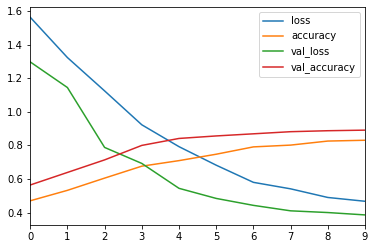

In [ ]:
modelLoss = pd.DataFrame(cnnModel.history.history)
modelLoss.plot()

**The training time is approximately 11 hours. It can be observed from the log and the plot above that loss and val_loss decreased over-epochs and for val_loss, it converged to approximately 0.35-0.45. The accuracy converged to approximately 89% based on the validating dataset.**

**In the following, the model is used to predict and classify datapoints in the validating dataset.**

In [ ]:
prediction = cnnModel.predict(X_test, verbose=1)

28/28 [==============================] - 261s 9s/step


In [ ]:
prediction

array([[2.4968447e-02, 8.7814163e-03, 1.5649035e-03, ..., 8.1658208e-01,
        1.0659819e-03, 4.0403218e-03],
       [1.0000000e+00, 1.6567867e-13, 3.1975487e-14, ..., 3.3168919e-11,
        4.2008529e-11, 1.1332211e-09],
       [9.9999988e-01, 4.0748477e-10, 1.4869493e-11, ..., 7.1202699e-08,
        6.0480193e-10, 3.9536197e-08],
       ...,
       [9.5747775e-01, 4.2006331e-03, 1.3147665e-03, ..., 1.6877156e-02,
        5.3530168e-03, 1.1605612e-02],
       [3.0331807e-07, 4.4420353e-06, 3.2591861e-06, ..., 8.7430993e-07,
        1.4617527e-07, 9.9999058e-01],
       [2.0568646e-01, 1.1183424e-01, 7.6366536e-02, ..., 1.2692723e-01,
        1.3342844e-01, 1.5307075e-01]], dtype=float32)

**Given the definition $L(p_{i})=-\log{p_{i}}$, a logloss of approximately 0.39 means that the right class is attributed to a probability of $e^{-0.5} = 0.677$ in average, which is quite high considering this is a multi-class classification problem with 8 classes. Note that the accuracy of the model is approxiamtely 89% when the training finished.**

**Save the model.**

In [ ]:
from sklearn.metrics import log_loss
print(log_loss(y_test, prediction))

0.3857140297798223


In [ ]:
cnnModel.save('cnnAdamFishMonitoring.h5')

In [ ]:
pwd

'/Users/lalits/Desktop/ADS_Final_Project'

**Predicting an unseen datapoint**


**Use the first CNN model to predict an unseen datapoint. The image is an albacore Tuna.**

In [ ]:
img = cv2.imread('./train/ALB/img_00496.jpg')
img = cv2.resize(img, dsize=(480, 270), interpolation=cv2.INTER_CUBIC)

df = np.ndarray((1, 270, 480, 3), dtype=np.uint8)
df[0] = img
cnnModel.predict(df)

array([[9.9990463e-01, 2.1973356e-06, 3.0857774e-07, 3.7651663e-08,
        1.1440741e-06, 3.8913771e-05, 8.8479946e-06, 4.3855485e-05]],
      dtype=float32)

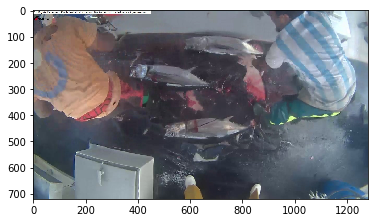

In [ ]:
import matplotlib.image as mpimg
img=mpimg.imread('./train/ALB/img_00496.jpg')
imgplot = plt.imshow(img)
plt.show()

**Note that the model assigns the albacore tuna class a probability of approximately 1, thus correctly predicting that the image contains an albacore tuna.**

**Conclusion**


* Illegal, unreported, and unregulated fisheries can be devastating to fish stocks and thus aggrevate the current trend of overfishing and extinction. Computer Vision and ML algorithms can provide an efficient and effective approach to monitor and enforce legal and sustainable fisheries on the high seas by automating the classification process of fish species based on images collected by the cameras on the fishing ships, and thus accelerating the video reviewing process. 


* In this notebook we made use of 1 CNN model using Adam optimizer implemented and trained on a dataset of 3000+ images. It is shown that the Adam optimizer is accurate enough. Overall, the CNN model with Adam optimizer achieves an accuracy of 89% and a logloss of 0.39, thus assigning the correct fish species class with a probability of 68% in average. It is concluded that the approach of identifying and classifiying fish species using CNN and Computer Vision is plausible and effective, and with larger dataset and more training, models can be developed to support fishery regulatory procedures by the Government or charitable organizations such as the Nature Conservancy.

**References**

[1] https://github.com/shawnhan108/nature-notebook/blob/master/The%20Nature%20Conservancy%20Fisheries%20Monitoring/The%20Nature%20Conservancy%20-%20Fisheries%20Monitoring.ipynb

[2] https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring

**License**

MIT License

Copyright (c) [2020] [Prasham Shah, Priyanka Bandekar]

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.